In [6]:
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import re
import spacy
import json
import os
import uk_core_news_lg
import time
import random

In [34]:
# спочатку вирішимо питання з отриманням текстів, щоб не вигадувати і не писати їх руцями

In [2]:
main_url = "https://www.work.ua"
cat_url = "/jobs-odesa-it/?setlp=ua"

In [3]:
res = requests.get(main_url + cat_url)


In [ ]:
res.status_code

In [ ]:
res.text

In [6]:
soup = BeautifulSoup(res.text, "lxml")

In [7]:
def get_soup(url):
    res = requests.get(url)
    soup = BeautifulSoup(res.text, "lxml")
    return soup

In [8]:
# створимо словник регулярних виразів під те що ми бажаємо шукати. Не знаю нащо словник. Люблю слоники

trigger_dict = {
    "vaction_url": r"^/jobs/\d+/$",
    "pagination": r"&page=\d+"
}


In [9]:
def get_href_data(regular, soup):
    data = [a["href"] for a in soup.find_all("a", href=True) if re.search(regular, a["href"])]
    return data

In [74]:
def get_pagination(soup, data=[], timeout=None):
    # отримуємо список відностних посилань
    avaliable_pages = get_href_data(trigger_dict["pagination"], soup)
    pag_page_base = "=".join(avaliable_pages[0].split("=")[:-1])
    pg_nums = [int(i.split("=")[-1]) for i in avaliable_pages]
    max_page = max(pg_nums)

    for pg in range(1, max_page + 1):
        data.append(main_url + pag_page_base + "=" + str(pg))
    
    if timeout is not None:
        time.sleep(timeout)

    return data

In [ ]:
page_list = get_pagination(soup)
page_list

In [499]:
def get_vacation_list(pg_list, timeout=None) -> list:
    data = []
    count = 0
    totaql_count = len(pg_list)

    for pg_url in pg_list:
        soup = get_soup(pg_url)
        res = get_href_data(trigger_dict["vaction_url"], soup)
        res = [main_url + i for i in res]
        data += res
        count += 1

        print(f"сторіка {count} / {totaql_count}: знайдено {len(data)} вакансій")

        if timeout is not None:
            time.sleep(timeout)
    return data

In [13]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time

In [ ]:
vacation_list = get_vacation_list(page_list)
print(len(vacation_list))
vacation_list = list(set(vacation_list))  # видалимо дублі, якщо вони є
print(len(vacation_list))



In [15]:
# нащо я пишу функції в ноутбуку - не понятно. Просто звичка.

In [16]:
# driver = webdriver.Chrome()

In [7]:
def save_vacations(data: list, filename: str):
    with open(f"{filename}.json", "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)

In [503]:
# страшні люди працююьб на work.ua - інфо про вакансії грузиться динамічно. Щоб не вичитувати усі запроси, просто використаємо selenium

def get_vacation_info(vacation_list, timeout=None):
    driver = webdriver.Chrome()
    data_list = []
    total_len = len(vacation_list)
    counter = 0

    for vac_url in vacation_list:
        driver.get(vac_url)
        vac_box = driver.find_element(by=By.CLASS_NAME, value="wordwrap")
        text = vac_url + "\n" + vac_box.text  # додамо посилання на вакансію до наого тексту
        data_list.append(text)
        counter += 1
        print(f"Прочитано {counter} / {total_len} вакансій")
        
        if timeout is not None:
            time.sleep(timeout)
            
    driver.close()
   
    return data_list
        


  

# NER із коробки

In [8]:
def get_data_from_json(filename):
    with open(filename, "r", encoding="utf-8") as file:
        data = json.load(file)
        return data


In [9]:
nlp = uk_core_news_lg.load()

In [10]:
vac_filename = "vactations_raw.json"
if os.path.exists(vac_filename):
    
    vacancy_data = get_data_from_json(vac_filename)
else:
    vacancy_data = get_vacation_info(vacation_list)
print(vacancy_data)

['https://www.work.ua/jobs/5317281/\nВакансія від 18 грудня 2024\nВище за середню\nAdministrator\n22\u202f000 грн\nAtlas Professionals, Агенція\n\nПошук персоналу, HR; 250–1000 співробітників\nОдеса, вулиця Середньофонтанська, 19Б.\n3,0 км від центруНа мапі\nElena Kukurudziak\nПоказати телефон\nПовна зайнятість. Також готові взяти студента. Вища освіта.\nАнглійська — вище середнього\nВакансію зараз переглядають 4 шукача. Відгукніться першим!\nОпис вакансії\nRemote Work\nJob Requirements\nEnglish: upper-intermediate or higher\nUniversity degree (last year students or direct university graduates can be considered)\nJob Description\nTimely receiving and correctly recording of time and expenses sheets;\nProcessing bookings (based on the above payroll related documentation) into both payments and sales invoices in CRM system;\nMore info:\nThis position would suit an individual that is looking to start their career or alternatively someone with previous office experience who is looking to ga

In [21]:
# driver.close()

In [11]:
for vac in vacancy_data[:5]:
    doc = nlp(vac)

    for ent in doc.ents:
        print(ent.text, "->", ent.label_)

Atlas Professionals -> ORG
Агенція

 -> ORG
Одеса -> LOC
вулиця Середньофонтанська, 19Б. -> LOC
Elena Kukurudziak -> LOC
Shared Service Centre Leader -> ORG
Elena Kukurudziak -> PER
Мерчендайзер -> LOC
Роздрібна торгівля; 250–1000 -> ORG
Одеса -> LOC
Нестле Україна -> ORG
ТМ Nestle -> ORG
ТМ Nestle Professional -> ORG
ТМ Purina -> ORG
ТМ Nescafe -> ORG
ТМ Світоч -> ORG
ТМ Торчин -> ORG
ТМ Мивина -> ORG
Україні -> LOC
Одеса -> LOC
7 Неба -> LOC
пн.-пт -> LOC
Жанна -> PER
Гордієнко -> PER
Агенція

 -> ORG
Одеса -> LOC
Міжнародна компанія -> ORG
FMCG -> ORG
Одеса -> LOC
України -> LOC
Одеса -> LOC
Тираспольське шосе -> LOC
Serpstat -> ORG
Google Search Console -> ORG
Google Analytics -> ORG
Google Analytics 4
Ahrefs
Screaming Frog SEO Spider -> ORG
Одеса -> LOC
вулиця Базова -> LOC
Татьяна -> LOC
Сб -> LOC
вул. Базова 12 -> LOC
милкі -> LOC
Google Excel -> ORG


In [23]:
# ннн-да. Явно бачимо що з варіантом "з коробки" щось іде не так. 
# додамо сутності для ЗП, посилань та графіка



# Entity Ruller 
додамо правила перед NER

In [24]:
# спочатку навчимо модель розрізняти посилання, дати, графік роботита зарплатню. Ми би могли це реалізувати і через регулярки, але ж ми вивчаємо spacy
# будемо використовувати Entity Ruller так як для полноцінного навчання моделі у нас немає такого обсягу даних, а парсити весь work.ua - їм може не сподобатись

In [12]:
# створимо наш улюблений словник де ключ - назва сутності, значення - регулярний вираз
# https://regex101.com/



ent_patterns = {
    "URL": r"https?://[^\s]+",
    "SALARY": r"[1-9]\d+\s*\d+\s?([-–]?\s?[1-9]\d+\s*\d*)?\s?грн",
    "FROM_DATE": r"від\s\d{1,2}\s\w+\s\d{4}", # схоже що тут все в однаковому форматі, тож не будемо ускладнювати
    "SCHEDULE": r"\wрафік.{0,}\d{1,2}.{0,}[\d\.)]"
}

In [13]:
from spacy.pipeline import EntityRuler

In [14]:
ruler = nlp.add_pipe("entity_ruler", before="ner") # додаємо entity_ruler в пайплайн перед ner


In [15]:
patterns = []

# створюємо правила та додаємо в ruller
for key, value in ent_patterns.items():
    rule = {"label": key, "pattern": [{"TEXT": {"REGEX": value}}]}
    patterns.append(rule)

ruler.add_patterns(patterns)

In [22]:
text = vacancy_data[3]
text

'https://www.work.ua/jobs/4890331/\nВакансія від 21 грудня 2024\nSEO-спеціаліст\n35\u202f000\u2009–\u200940\u202f000 грн, + бонуси за результати\nAger\n\nОптова торгівля, дистрибуція, імпорт, експорт; 10–50 співробітників\nОдеса, Тираспольське шосе, 15б.\n6,6 км від центруНа мапі\nПовна зайнятість. Досвід роботи від 2 років.\nВакансію зараз переглядають 2 шукача. Відгукніться першим!\nSEO\nТайм-менеджмент\nCRM\nSerpstat\nGoogle Search Console\nGoogle Analytics\nGoogle Analytics 4\nAhrefs\nScreaming Frog SEO Spider\nNetpeak Spider\nОпис вакансії\nAGER.ua — амбіційний український інтернет-магазин одягу\nШукаємо досвіченого SEO спеціаліста з успішним досвідом просування великих проектів.\nОбов’язки\n1. Сформувати стратегію SEO-просування.\n2. Реалізувати стратегію SEO-просування.\nВимоги\n1. Успішні кейси просування великих інтернет-магазинів, в ідеалі — у тематиці одягу.\n2. Прозорість роботи, детальний план та можливість розуміти, на якій стадії його реалізації ми знаходимося у кожний м

In [23]:

doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

https://www.work.ua/jobs/4890331/ URL
Одеса LOC
Тираспольське шосе LOC
Serpstat ORG
Google Search Console ORG
Google Analytics ORG
Google Analytics 4
Ahrefs
Screaming Frog SEO Spider ORG


In [24]:
# тепер ми бачимо url, але не бачимо ЗП, графіка і тд. Тобто вцілому воно працює, але є нюанс: токінайзер розбиває документ по пробілам, 
# тож наші регулярки дивляться на кожен токен, який явно не підходить під регулярку
for token in doc:
    print(token.text)

https://www.work.ua/jobs/4890331/


Вакансія
від
21
грудня
2024


SEO
-
спеціаліст


35
 
000
 
–
 
40
 
000
грн
,
+
бонуси
за
результати


Ager



Оптова
торгівля
,
дистрибуція
,
імпорт
,
експорт
;
10–50
співробітників


Одеса
,
Тираспольське
шосе
,
15б
.


6,6
км
від
центруНа
мапі


Повна
зайнятість
.
Досвід
роботи
від
2
років
.


Вакансію
зараз
переглядають
2
шукача
.
Відгукніться
першим
!


SEO


Тайм
-
менеджмент


CRM


Serpstat


Google
Search
Console


Google
Analytics


Google
Analytics
4


Ahrefs


Screaming
Frog
SEO
Spider


Netpeak
Spider


Опис
вакансії


AGER.ua
—
амбіційний
український
інтернет
-
магазин
одягу


Шукаємо
досвіченого
SEO
спеціаліста
з
успішним
досвідом
просування
великих
проектів
.


Обов’язки


1
.
Сформувати
стратегію
SEO
-
просування
.


2
.
Реалізувати
стратегію
SEO
-
просування
.


Вимоги


1
.
Успішні
кейси
просування
великих
інтернет
-
магазинів
,
в
ідеалі
—
у
тематиці
одягу
.


2
.
Прозорість
роботи
,
детальний
план
та
можливість
розуміти
,
на
якій

In [ ]:
# в такому випадку ми можемо створити кастомний компонент і додати його в кінець пайплана. 



# Додавання своїх функцій в pipline

In [25]:
from spacy.language import Language

In [26]:
print(type(doc.ents))

<class 'tuple'>


In [27]:
@Language.component("regex_component")
def regex_component(doc): # приймає документ повністю (не токенізований)
    current_ents = list(doc.ents) # зберігаємо ті сутності, що знайшов ner
    text = doc.text

    for label, reg_extension in ent_patterns.items():  # ent_patterns - глобальна змінна, спочатку думали передавати функцію лямбдою, але так не можна
        for match in re.finditer(reg_extension, text): # повертає всі групи, знайдені по регулярному виразу разом з індексом першого та останнього символу
            first, last = match.span()
            ent = doc.char_span(first, last, label=label) # створюємо нову сутність
            if ent is not None:
                # doc.ents += (ent,) # ого, чомусь так не можна
                current_ents.append(ent)
                
    doc.ents = tuple(current_ents) # оновлений список обратно переводимо в кортеж та присвоюємо його значення doc.ents

    return doc



In [28]:
nlp = uk_core_news_lg.load()
nlp.add_pipe("regex_component", last=True) # додаємо нашу функцію в кінець пайплана nlp !!! spacy не вміє в lambda!

<function __main__.regex_component(doc)>

In [29]:
from collections import defaultdict

In [30]:
text = vacancy_data[3]

doc = nlp(text)

vacation_ents = defaultdict(list)
for ent in doc.ents:
    clean_text = ent.text.replace("\u202f", "")  # видаляємо тонкий пробіл (кращє було раніше, але ок)
    vacation_ents[ent.label_].append(clean_text) if clean_text not in vacation_ents[ent.label_] else ...

print(vacation_ents)

defaultdict(<class 'list'>, {'URL': ['https://www.work.ua/jobs/4890331/'], 'FROM_DATE': ['від 21 грудня 2024'], 'SALARY': ['35000\u2009–\u200940000 грн'], 'LOC': ['Одеса', 'Тираспольське шосе'], 'ORG': ['Serpstat', 'Google Search Console', 'Google Analytics', 'Google Analytics 4\nAhrefs\nScreaming Frog SEO Spider'], 'SCHEDULE': ['Графік роботи: Пн-пт 9:00 — 18:00']})


тепер ми наче отримуємо всі сутності, але знову ж таки є нюанс: по факту ми просто написали функцію, яка просто пропускає текст через регулрні вирази та помістили її в кінець пайплана. Все теж саме ми могли б зробити і окремо: подати текст в nlp, а потім щє раз пропустити його через функцію з регулярками і зібрати це все в один результат. Зручність тільки в тому, що довелось писати меньше літер. Хоча останнє і приємно, але наш алгоритм має суттєве обмеження: якщо NER розуміє контектст і може вилучити сутності з будь-якого тексту (умовно), то наша функція не сприймає контекст, а просто перевіряє текст регулярним виразом і якщо є матч - просто створює сутність. Цього може бути не достатньо, якщо б ми хотіли, наприклад, посилання на телеграм отримати як сутність CONTACTS. Можна було б написати і під це регулярку, але: по-перше: на все регулярок не напишешся; по-друге: функція має асемптотичну складність О(len(ent_patterns.keys())). 

# Донавчання NER
спробуємо тихенько спарсити вакансії з work.ua, потім модифікуємо наші регулярки так, щоб вони забирали ціле речення. Створимо датасет, навчимо модель і подивимось, що вийде. 

 Збір даних

In [ ]:
# спочатку модифікуємо нашу функцію парсингу щоб вона могла обробляти декілька категорій

# cat_url_list = ["/jobs-odesa-it/?setlp=ua", "/jobs-odesa-administration/?setlp=ua", "/jobs-odesa-logistic-supply-chain/?setlp=ua", "/jobs-odesa-sales/?setlp=ua", "/jobs-odesa-retail/?setlp=ua", "/jobs-odesa-customer-service/?setlp=ua"]
cat_url= "/jobs-kyiv/?setlp=ua"  # просто візьмемо всі вакансії в Києві. Там 22к вакансій. Даних має вистачити для навчання.
data_pages = []


url = main_url + cat_url
# print(f"скануємо категорію {url}:\n")
soup = get_soup(url)

pag_list = get_pagination(soup, data_pages, 0.3)

print(len(data_pages), data_pages[:5])
    

In [ ]:
vacation_list = get_vacation_list(data_pages, timeout=0.3)
print(len(vacation_list))
vacation_list = list(set(vacation_list))  # видалимо дублі, якщо вони є
print(len(vacation_list), vacation_list[:5])

In [502]:
save_vacations(vacation_list, "kyiv_vac_urls")

In [ ]:
# маємо 23199 унікальних посилань на вакансії

In [ ]:
vacation_texts = get_vacation_info(vacation_list, timeout=0.5)

In [ ]:
# на 19516 вакансії згадав, що раз ми використовуємо selenium, то нам нічого не коштувало б отримувати і номери телефонів,
#  тоді б щє могли створити одну сутність з номером телефона.  Але вже переривати не будемо.

In [532]:

save_vacations(vacation_texts, "kyiv_vacations_texts") # невірно зберегли, тож збережемо зараз

In [32]:
vacation_texts = get_data_from_json("kyiv_vacations_texts.json")

In [33]:
len(vacation_texts)

23197

In [7]:
sntns_patterns = {
    "URL": r"[А-Я][^.\n]*?https?://[^\s\n]+[^\n]*?\n",#r"[А-Я][^.\n]*https?://[^\n]*\n", # навмисно рядок з великоїбукви, щоб не витягнути посилання на сторінку вакансії
    "SALARY": r"[А-Я][^.\n]*?[1-9]\d+\s*\d+\s?([-–]?\s?[1-9]\d+\s*\d*)?\s?грн[^\n]*?\n",#r"[А-Я][^.\n]*[1-9]\d+\s*\d+\s?([-–]?\s?[1-9]\d+\s*\d*)?\s?грн[^\n]*\n",
    "SCHEDULE": r"[А-Я][^.\n]*?(раф[іи]к|час роботи)[^\n]*?\d+.*?\n"#r"[А-Я][^.\n]*([Гг]?раф[іи]к|час роботи)([^\n]*\d+)+\n",
    #"ADDRESS": r"[А-Я][^.\n]*?([Вв]?[Уу]лиц[ая]|[Пп]росп)[^\n]*?[А-Я][^\n]*?\d+[^\n]*?\n",#r"[А-Я][^.\n]*([Вв]?[Уу]лиц[ая]|[Пп]росп)[^\n]*[А-Я][^\n]*\d+[^\n]*\n"



}

# сформуємо словник, регулярки якого будуть забирати цілі речення

In [110]:
ents_patterns = {
    "URL": r"https?://[^\s]+", 
    "SALARY": r"[1-9]\d+\s*\d+\s?([-–]?\s?[1-9]\d+\s*\d*)?",
    "SCHEDULE": r"(\d{1,2}[:−]\d{2}.*?(?:\d{1,2}[:−]\d{2})?|гнучкий.*?|пн.*?вихідні|[1-9]\d*[\/−][1-9]\d*.*?)",
    #"ADDRESS": r"([Вв]?[Уу]лиц[ая]|[Пп]росп)[^\n]*[А-Я][^\n]*\d+"

}

In [9]:
vacation_texts[:10]

["https://www.work.ua/jobs/3855925/\nВакансія від 20 грудня 2024\nРегіональний менеджер із закупівлі зернових та олійних культур\nФенікс Агро\n\nСільське господарство, агробізнес; 50–250 співробітників\nКиїв, вулиця Михайла Драгомирова, 2А.\n4,3 км від центруНа мапі\nПовна зайнятість. Досвід роботи від 1 року. Вища освіта.\nВакансію зараз переглядає 1 шукач. Відгукніться першим!\nMS Word\nMS Excel\nКористувач ПК\nЗнання законодавства України\nВідповідальність\nКомунікабельність\nСтресостійкість\nПоказати всі навички\nОпис вакансії\nОпис вакансії\nКомпанія «Фенікс Агро» у зв`язку з розширенням запрошує у свою команду «Регіонального менеджера із закупівлі зернових та олійних культур».\nОбов’язки:\nОрганізація ефективного процесу закупівлі у ввіреному регіоні\nВиконання показників із закупівлі зернових та олійних культур\nРозвиток потенціалу регіону: пошук партнерів, створення нової бази клієнтів та постачальників\nВедення переговорів з с/г виробниками\nМоніторинг ринку виробників с/г про

In [10]:

for text in vacation_texts[950:1000]:
    # Знаходимо всі збіги, поки нема сенсу отримувати початковий і кінцевий індекс збігу, так як індекси будуть для вього тексту, а не для речення
    for label, pattern in sntns_patterns.items():

        for match in re.finditer(pattern, text, flags = re.DOTALL):
            if label == "SCHEDULE":
                print(label, "=>", match.group())



SCHEDULE => Графік роботи: 8−18, + 2 суботи за плаваючим графіком.

SCHEDULE => Гнучкий графік роботи — 4/2.

SCHEDULE => Графік роботи: з 10:00 до 19:00, 22 робочих днів на місяць.

SCHEDULE => Гнучкий позмінний графік роботи 4/4 5/2 7/7.

SCHEDULE => Графік роботи: 5/2

SCHEDULE => Графік роботи з 08:00 до 17:00 або з 09:00 — 18:00, 5/2.

SCHEDULE => Графік роботи Пн-Пт з 9:00 до 18:00;

SCHEDULE => Графік роботи: з 10:00 до 20:00, 2 через 2

SCHEDULE => Графік роботи 5/2 (пн — пт)

SCHEDULE => Графік роботи: понеділок — п’ятниця з 9:00 — 18:00.

SCHEDULE => Графік роботи: з 9:00 до 18:00 (5/2 сб. нд. вихідні),

SCHEDULE => Графік з 9−00 до 19−00.

SCHEDULE => Графік роботи: Пн.- Пт. з 09:00 — 18:00

SCHEDULE => Стабільний та зручний графік роботи — 09:30 — 21:00, 3/2;



In [12]:
# завдяки нашому таланту писати неоптимальні регулярки процесс знаходження речень виявився максимально довгим. Тож розкидаємо цю задачу на всі процессори
from concurrent.futures import ProcessPoolExecutor

In [30]:
def pool_executor(data, patterns, process_func) -> list:
    total = len(data) 
    
    with ProcessPoolExecutor() as executor: # паралельна обробка текстів
        results = list(executor.map(
            process_func, 
            [(text, patterns, i, total) for i, text in enumerate(data)]
        ))

    # print("об'єднання результатів...")
    all_sentences = [sentence for result in results for sentence in result]
    # print(f"всього знайдено {len(all_sentences)} співпадінь")
    return all_sentences


In [31]:
def get_sentenses(args) -> list:
    # обробляє один текст за раз, повертає список рядків
    text, sntns_patterns, index, total = args
    sentences = []
    # print(f"[пошук в реченні {index}]")
    for label, pattern in sntns_patterns.items():
        # print(f"[{index + 1}] пошук {label}...")
        for match in re.finditer(pattern, text, flags=re.DOTALL):
            sentences.append(match.group().replace("\n", ""))

    # print(f"[{index + 1}/{total}]: знайдено {len(sentences)} співпадінь в реченні")
    return sentences

In [ ]:
# sentenses = pool_executor(vacation_texts, sntns_patterns, get_sentenses)

In [ ]:
# останні 10 речень обробляємо дуже довго. 

# UPD: видалення індексів на яких відбувається "зависання" не допомогає. Теоретично процес може швидко обробити задачу і потім разом з іншим звернутись до однієї і тої. 
# Але це малоімовірно, так як тут точно має бути реалізован механізм блокування під капотом

# UPD: мультіпроцессінг особо не допоміг

# UPD: тестування окремих слайсів в які входять індекси на яких відбувається "зависання" покахало що проблема не в текстах і не в регулярках

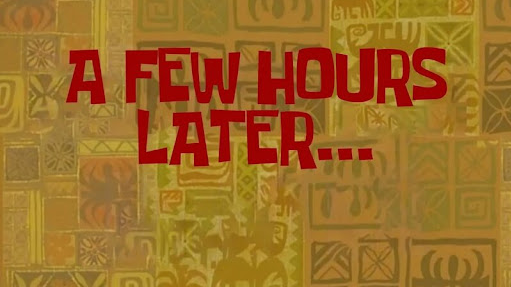

In [32]:
def slice_and_proceed(data:list, step:int, func, patterns:dict, timeout:int|float=1) -> list:
    result_list = []
    start = 0
    data_len = len(data)

    while start < len(data):
        end = min(start + step, data_len) # щоб не вилетіти за індекс
        result_list += pool_executor(data[start:end], patterns, func)
        print(f"[блок {start}:{end}]: знайдено {len(result_list)} співпадінь")
        start = end
        time.sleep(timeout)

    return result_list

In [27]:
sentes_list = slice_and_proceed(vacation_texts, 200, get_sentenses, sntns_patterns)

[блок 0:200]: знайдено 103 співпадінь
[блок 200:400]: знайдено 203 співпадінь
[блок 400:600]: знайдено 308 співпадінь
[блок 600:800]: знайдено 408 співпадінь
[блок 800:1000]: знайдено 528 співпадінь
[блок 1000:1200]: знайдено 626 співпадінь
[блок 1200:1400]: знайдено 730 співпадінь
[блок 1400:1600]: знайдено 830 співпадінь
[блок 1600:1800]: знайдено 945 співпадінь
[блок 1800:2000]: знайдено 1045 співпадінь
[блок 2000:2200]: знайдено 1170 співпадінь
[блок 2200:2400]: знайдено 1289 співпадінь
[блок 2400:2600]: знайдено 1396 співпадінь
[блок 2600:2800]: знайдено 1499 співпадінь
[блок 2800:3000]: знайдено 1591 співпадінь
[блок 3000:3200]: знайдено 1683 співпадінь
[блок 3200:3400]: знайдено 1792 співпадінь
[блок 3400:3600]: знайдено 1910 співпадінь
[блок 3600:3800]: знайдено 2008 співпадінь
[блок 3800:4000]: знайдено 2130 співпадінь
[блок 4000:4200]: знайдено 2233 співпадінь
[блок 4200:4400]: знайдено 2330 співпадінь
[блок 4400:4600]: знайдено 2426 співпадінь
[блок 4600:4800]: знайдено 2519

In [ ]:
# тепер я люблю не тільки словники, але і зрізи

In [33]:
sentes_list[:5]

['Компенсацію смачних обідів (економія для твого гаманця в 4000 грн);',
 'Можливість працювати повний місяць (із зарплатою 30 000 грн.)',
 'З/П мінімально від 25000 грн;',
 'Графік роботи 5/2 + чергові зміни;',
 'Зручний графік роботи: Понеділок — П’ятниця, з 08:00 до 18:00.']

In [28]:
def get_training_data(args) -> list:
    # виокремлює мітки майбутніх сутностей, іх ідекси і створює список кортежей для тренування spacy.
    # одне речення за раз
    # повертає список кортежей
    text, patterns, index, total = args
    training_data = []

    for label, pattern in patterns.items():
        for match in re.finditer(pattern, text, flags= re.DOTALL):
            # if label == "LOC":
            #     print(label, "=>", match.group())
                first, last = match.span()
                training_data.append((text, [(first, last, label)]))
    # print(f"[{index + 1}/{total}]: знайдено {len(training_data)} співпадінь в реченні")
    return training_data

In [111]:
training_data = slice_and_proceed(sentes_list, 200, get_training_data, ents_patterns)

[блок 0:200]: знайдено 348 співпадінь
[блок 200:400]: знайдено 669 співпадінь
[блок 400:600]: знайдено 1031 співпадінь
[блок 600:800]: знайдено 1389 співпадінь
[блок 800:1000]: знайдено 1764 співпадінь
[блок 1000:1200]: знайдено 2084 співпадінь
[блок 1200:1400]: знайдено 2442 співпадінь
[блок 1400:1600]: знайдено 2819 співпадінь
[блок 1600:1800]: знайдено 3152 співпадінь
[блок 1800:2000]: знайдено 3518 співпадінь
[блок 2000:2200]: знайдено 3849 співпадінь
[блок 2200:2400]: знайдено 4188 співпадінь
[блок 2400:2600]: знайдено 4525 співпадінь
[блок 2600:2800]: знайдено 4899 співпадінь
[блок 2800:3000]: знайдено 5256 співпадінь
[блок 3000:3200]: знайдено 5585 співпадінь
[блок 3200:3400]: знайдено 5939 співпадінь
[блок 3400:3600]: знайдено 6260 співпадінь
[блок 3600:3800]: знайдено 6602 співпадінь
[блок 3800:4000]: знайдено 6943 співпадінь
[блок 4000:4200]: знайдено 7272 співпадінь
[блок 4200:4400]: знайдено 7628 співпадінь
[блок 4400:4600]: знайдено 7976 співпадінь
[блок 4600:4800]: знайде

In [112]:
training_data[:5]

[('Компенсацію смачних обідів (економія для твого гаманця в 4000 грн);',
  [(57, 62, 'SALARY')]),
 ('Можливість працювати повний місяць (із зарплатою 30 000 грн.)',
  [(49, 56, 'SALARY')]),
 ('З/П мінімально від 25000 грн;', [(19, 25, 'SALARY')]),
 ('Графік роботи 5/2 + чергові зміни;', [(14, 17, 'SCHEDULE')]),
 ('Зручний графік роботи: Понеділок — П’ятниця, з 08:00 до 18:00.',
  [(47, 52, 'SCHEDULE')])]

In [113]:
save_vacations(training_data, "kyiv_training_data")

In [44]:
from collections import Counter

# подивимось скільки яких сутностей ми зібрали

In [114]:
ent_counts = Counter()

for _, annotations in training_data:
    for start, end, label in annotations:
        ent_counts[label] += 1

for label, count in ent_counts.items():
    print(f"{label}: {count}")

SALARY: 4428
SCHEDULE: 14402
URL: 2342


In [115]:
# бачимо суттєвий дісбаланс в сторону графіків. Зменшимо їх кількість, з урахуванням того, що графіки роботи пишуть взагаля як-попало, залишимо всеж більше прикладів

non_scheldue_list = [item for item in training_data if 'SCHEDULE' not in str(item)]
scheldue_list  = [item for item in training_data if 'SCHEDULE' in str(item)]
training_data = non_scheldue_list + random.sample(scheldue_list, k=5000) # створюємо новий список де рандомно залишаємо лише 4000 зразків сутностей SCHEDULE

In [42]:
from spacy.tokens import DocBin
from spacy.training.example import Example

In [ ]:
!python -m spacy init config config.cfg --lang uk --pipeline ner --optimize efficiency


In [ ]:
!python -m spacy init fill-config config.cfg config_filled.cfg

In [116]:
from sklearn.model_selection import train_test_split
train_data, dev_data = train_test_split(training_data, test_size=0.2, random_state=42, shuffle=True)  # спробуємо без stratify

In [118]:
# це з документації spacy... Суть в тому що ми примусово доємо сутності з їх імовірним виглядом, зберігаємо і використовуємо для тренування

nlp = spacy.load("uk_core_news_lg")
db = DocBin()

# for text, annotations in train_data:
for text, annotations in dev_data:
    doc = nlp(text)
    ents = []
    for start, end, label in annotations:
        span = doc.char_span(start, end, label=label, alignment_mode='expand') # alignment_mode='expand' -> для лінивих, прибирає зайві символи пунктуації
        ents.append(span)
    doc.ents = ents
    db.add(doc)
    
# db.to_disk("./train.spacy")
db.to_disk("./dev.spacy")

In [ ]:
!python -m spacy train config_filled.cfg --output ./output --paths.train train.spacy --paths.dev dev.spacy


In [119]:
!python -m spacy train config_filled.cfg --output ./output --paths.train ./train.spacy --paths.dev ./dev.spacy

# спробуємо на CPU, якщо буде довго - налаштуємо під GPU. 
# UPD: spacy має вже вбудований механізм earlystopping також вона працює на трансформерах та RNNN які навчаються дорого для пам'яті, але не для процессора, 
# тому нам на процессорі - ок

ℹ Saving to output directory: output
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     49.00    0.00    0.00    0.00    0.00
  0     200         47.59   2286.63   57.34   66.37   50.47    0.57
  0     400         51.74   1748.84   57.32   68.75   49.15    0.57
  0     600         48.18   2085.36   62.06   69.15   56.29    0.62
  0     800         68.29   2534.04   58.53   74.27   48.30    0.59
  1    1000        385.77   2973.94   64.80   64.73   64.87    0.65
  1    1200         79.45   3510.30   63.63   70.30   58.11    0.64
  2    1400        104.07   4140.41   59.47   76.18   48.77    0.59
  2    1600        127.73   509

In [244]:
custom_nlp = spacy.load("output/model-best") # завантажуємо нашу донавчену модель

In [121]:
ner = custom_nlp.get_pipe("ner")
labels = ner.labels
print(labels) # як бачимо, ми донавчили модель, але втратили старі сутності

('SALARY', 'SCHEDULE', 'URL')


In [138]:
def get_entities(model, data):
    index = random.randint(0, len(data) - 1)
    text = data[index]
    doc = model(text)
    ent_string = ""
    for ent in doc.ents:
        clean_text = ent.text.replace("\u202f", "")  # видаляємо тонкий пробіл (кращє було раніше, але ок)
        # vacation_ents[ent.label_].append(clean_text) if clean_text not in vacation_ents[ent.label_] else ...
        ent_string += f"{ent.label_} => {clean_text}\n"
    
    print(f"{ent_string}\n{'_' * 30}\n\n{text}")

In [155]:
get_entities(custom_nlp, vacation_texts)
# у salary активно попадає дата на кшталт 27 грудня.  Ідемо наверх та видаляємо з регулярки SALLARY грн. І знов навчаємо модель
# UPD: після видалення із регулярки "грн", дата більше не попадає

URL => https://www.work.ua/jobs/5970312/
SALARY => 1700
SALARY => 17 000
SALARY => 20 000
SCHEDULE => 1/3

______________________________

https://www.work.ua/jobs/5970312/
Гаряча
Відгук без резюме
Бронювання
Оператор контакт-центру (подобово)
17 000 – 20 000 грн, 1700 за зміну + бонуси
Венбест, ТОВ

Охорона, безпека; більше 1000 співробітників
Київ, Берестейський проспект, 90/1.
8,7 км від центруНа мапі
Арцимович Єлизавета
Показати телефон
Повна зайнятість, неповна зайнятість.
Українська — вільно
Бронювання працівників
Вакансію зараз переглядають 3 шукача. Відгукніться першим!
MS Word
MS Office
MS Excel
Користувач ПК
Впевненість
Комунікабельність
Стресостійкість
Робота з клієнтами
Самостійність
Надійність
Опис вакансії
ВЕНБЕСТ піклується про безпеку своїх клієнтів вже понад 30 років. Допомагає кожному українцю відчувати впевненість у захисті всіх сфер життя. Турбується про особисту безпеку і спокій близьких, охороняє будинки, дивиться за авто, захищає бізнес.
Саме зараз у тебе є можли

перевіривши результати стає ясно що: 
1. потрібно частіше користуватись регулярками
2. потрібен або більш детальний препроцессінг даних перед навчанням, або більше даних, скориш і те і те

Але ми втратили сутності що були і парацювали стабільно. Немає простого способу їх зберегти: або ми подаємо приклади з ними під час донавчання, або ми їх втрачаємо. Що підводить нас до наступного розділу домашки яку можна було б виконати в 6 строчок

# Crutch Engineering

як тимчасове рішення, якщо ми дуже бажаємо порівняти сутності які надаються із коробки з нашими оригінальними сутностями, але при цьому не маємо навчальних даних, щоб при дотренуванні моделі зберегти її сутності, ми просто можемо написати кастомний компонент пайплайна, який буде використовувати оригінальну модель. При цьому потрібно розуміти, що по факту ми використовуємо дві окремі моделі, що тягне за собою усі мінуси такого підходу.

In [245]:
original_nlp = spacy.load("uk_core_news_lg")
ner = original_nlp.get_pipe("ner")
labels = ner.labels
print(labels) # як бачимо, ми донавчили модель, але втратили старі сутності

('LOC', 'ORG', 'PER')


In [246]:
original_nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [247]:
print(custom_nlp.pipe_names)  # бачимо що тут у нас тільки токенайзер на ner

['tok2vec', 'ner']


In [249]:
@Language.component("custom_nlp_component")
def custom_nlp_component(doc):
    current_ents = list(doc.ents) # зберігаємо ті сутності, що знайшов ner
    custom_doc = custom_nlp(doc.text)
    custom_ents = list(custom_doc.ents)

    combined_ents = list(set(current_ents + custom_ents))
    
    valid_ents = []

     # Перевіряємо, чи можна створити Span із заданими параметрами, якщо можна - додаємо, якщо не можна - така сутність вже є, або з нею інша проблема.
     # перестало сипати помилки про наявність сутності зі схожими параметрами
    for ent in combined_ents:
        try:
            span = doc.char_span(ent.start_char, ent.end_char, label=ent.label_)
            if span is not None:
                valid_ents.append(span)
        except ValueError:
            pass
    doc.ents = tuple(combined_ents) # оновлений список обратно переводимо в кортеж та присвоюємо його значення doc.ents

    return doc

In [251]:
original_nlp.add_pipe("custom_nlp_component", last=True)
print(original_nlp.pipe_names) 

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner', 'custom_nlp_component']


In [305]:
get_entities(original_nlp, vacation_texts)

URL => https://www.work.ua/jobs/6070923/
SALARY => 1200
LOC => Нью Сайд
ORG => Маркетинг
LOC => Київ
LOC => вулиця Василя Липківського, 37в
URL => https://hooligun.com.ua/
ORG => Вища освіта
Високий рівень організаційних навичок
SCHEDULE => 10:00—19:00

______________________________

https://www.work.ua/jobs/6070923/
Вакансія від 16 грудня 2024
Адміністратор фотостудії (на вихідні)
1200 грн за зміну
Нью Сайд, рекламне агентство

Маркетинг, реклама, PR; 10–50 співробітників
Київ, вулиця Василя Липківського, 37в.
3,9 км від центруНа мапі
Неповна зайнятість. Також готові взяти студента. Досвід роботи від 1 року. Вища освіта.
Вакансію зараз переглядає 1 шукач. Відгукніться першим!
Користувач ПК
Комунікабельність
Відповідальність
Організаторські здібності
Організованість
Відеозйомка
Адміністративна робота
Робота з клієнтами
Ввічливість
Опис вакансії
Вакансія: Адміністратор вихідного дня в фотостудію
Шукаємо в нашу фотостудію https://hooligun.com.ua/ відповідального та організованого праців

в пайплайн ми можемо додавати скільки бажаємо своїх моделей та функцій, при цьому розширюючи функціонал та створюючи бульш простий код для розуміння і використання. 
